# Practical Class 5 - Noise modelling

<p align="justify">
Noise is a very important factor in the design of a system. It is important to know how much noise is generated by a system and how much noise is introduced into the system by the surrounding environment/systems. This practical class covers how to model noise in a converter, and what are the impacts of the several sources of noise in the overall performance.
</p>

<p align="justify">
There are three primary noise sources in a converter:
<ul>
    <li>Quantization Noise (Quantization Error Noise model aproximated by a uniform distribution)</li>
    <li>Gaussian Noise (Innevitable source of noise, in the form of thermal, quantic and other electromagnetic phenomena happening in the circuit blocks)
    <ul>
        <li>Thermal Noise</li>
        <li>Shot Noise</li>
    </ul>
    </li>
    <li>Jitter Noise (Phase Noise generated by the random switching time stamps of the switches in the converter)</li>
</ul>
</p>

<p align="justify">
The complete model of a Analog-to-Analog converter signal chain is presented in the figure below, including the noise sources and the noise propagation through the system.

<p align="center">
<img src="../docs/imgs/total_output_noise.png" width="400">
</p>

</p>

In [21]:
import numpy as np
from scipy.constants import k
from numpy.random import uniform, normal # import uniform and normal probability distributions to represent noise
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.set_palette('colorblind')

from utils import bin2dec, dec2bin, ideal_dac, ideal_adc, nonideal_adc

In [22]:
# define the number of simulation points
Np = 1000
# define the frequency of the sampling clock
Fclk = 100e3 # Hz
# define the time base
dt = 1/Fclk
tD = np.arange(0, Np*dt, dt)

<h2 align="left">Jitter Noise Modelling</h2>

<p align="justify">
As stated before, jitter noise can be thought of a representation of the time uncertainty at which the sampling switches sampled an analog signal. The uncertainty at which the time the sampled was taken will introduce an error on the value of the sampled signal, at the corresponding sampling instant. 
</p>

<p align="center">
<img src="../docs/imgs/jitter_noise.png" width=400>
</p>

The sampled signal error can be represented by:
$$ s[n] = s(n*T_S + \Delta t_j) = s(n*T_S) + \epsilon_s$$

Considering a sinusoidal signal s(t) given by:

$$ s(t) = A \hspace{2 pt} sin(2\pi f_S t + \phi) $$


<p align="justify">
then using a first order taylor series aproximation of the sampled sinusoidal signal, we can obtain the contribution of the jitter noise to the error of the sampled signal:
</p>

$$ s[n] = A \hspace{2 pt} sin(2\pi f_S (nT_S + \Delta t_j)) \approx A \hspace{2 pt} sin(2\pi f_S (nT_S)) + A 2\pi f_S \Delta t_j \hspace{2 pt} cos(2\pi f_S (nT_S) ) $$

<p align="juustify">
The power of the reuslting signal can be separated into two main components, the power of the signal and the power of the jitter noise:
</p>

$$ P = P_s + P_j = \frac{A^2}{2} + \frac{A^2}{2}f_S^24\pi^2\sigma_t^2 $$

where $\sigma_t$ is the standard deviation of the random variable with normal distribution modelling the time uncertainty error $\Delta t_j$ - referred to as jitter -, $f_S$ is the sampling frequency and $A$ is the amplitude of the analog signal being sampled.

In [23]:
# let us create an ideal adc featuring jitter noise
# define the adc
nbit = 10
vref = 1
vlsb = vref/(2**nbit)
# define the input signal
A1 = vref/2 # V
f1 = 1e3 # Hz
# setup the input signal frequency to behold 
# coherent sampling
f1 = np.round(f1/Fclk* Np)*Fclk/Np # Hz
ph1 = 0 # rad

mV = 1e-3 # V
dc_level = vref/2

# setup the jitter noise
sig_t = 1e-7# sigma_t
jitter_stdev = A1*Fclk*sig_t*2*np.pi # jitter amplitude = jitter standard deviation
jitter_noise = jitter_stdev*normal(0, jitter_stdev, Np)
si = A1*np.sin(2*np.pi*f1*tD + ph1) + dc_level + jitter_noise
# define the dout 
dout = np.round(si / vlsb).astype(int)

/var/folders/vv/xctyh4bd2td6k2w_gvh_t2vr0000gn/T/ipykernel_60821/3403075116.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{val/v_scale:.1f}" for val in x_ticks[::freq]])


Text(0.5, 0, 'Jitter Noise - Std. Dev (mV)')

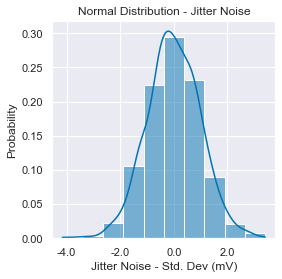

In [24]:
# observe the jitter noise probability density function
fig, ax = plt.subplots(1,1, figsize=(4,4))
freq = int(1)
v_scale = mV
sns.histplot(jitter_noise, ax=ax, stat="probability", bins=10, kde=True)
x_ticks = ax.get_xticks()
ax.set_xticklabels([f"{val/v_scale:.1f}" for val in x_ticks[::freq]])
ax.set_ylabel("Probability")
ax.set_title("Normal Distribution - Jitter Noise")
ax.set_xlabel("Jitter Noise - Std. Dev (mV)")

Text(0.5, 1.0, 'Input signal and output code')

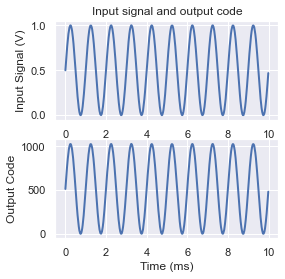

In [25]:
t_scale = 1e-3 # ms
# observe dout and s3
fig, ax = plt.subplots(2, 1, figsize=(4, 4))
ax[0].plot(tD/t_scale, si, color="b", linewidth=2)
ax[0].set_ylabel("Input Signal (V)")    
ax[1].plot(tD/t_scale, dout, color="b", linewidth=2)
ax[1].set_xlabel("Time (ms)")
ax[1].set_ylabel("Output Code")
ax[0].grid(True)
ax[1].grid(True)
ax[0].set_title("Input signal and output code")

In [26]:
# compute the snr of the adc
f_scale = 1e3
p_scale = 1

virt_zero = 1e-30

fD = np.fft.fftshift(np.fft.fftfreq(Np, dt))
# compute the fft of the dout signal 
dout_f = np.abs(np.fft.fftshift(np.fft.fft(dout) / Np))
dout_p = (dout_f*dout_f)
dout_p[dout_p == 0] = virt_zero
dout_db = 10*np.log10(dout_p)

Text(0.5, 1.0, 'Dout Frequency Spectrum - Jitter Noise Superposition')

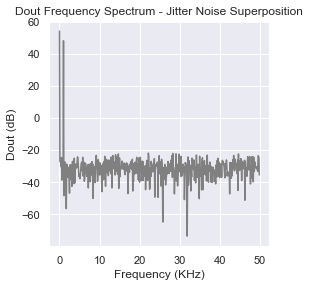

In [27]:
# observe the spectrum
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(
    fD[fD >= 0]/f_scale, dout_db[fD >= 0]/p_scale,
    color="gray",
    marker="None",   
)
ax.grid(True)
ax.set_xlabel("Frequency (KHz)")
ax.set_ylabel("Dout (dB)")
fig.tight_layout()
ax.set_title("Dout Frequency Spectrum - Jitter Noise Superposition")

In [28]:
# compute the snr of the adc
# snr computation 
bins = 1

fDp = fD[fD>=0]
dout_p_fp = dout_p[fD>=0]

fin_bin = fDp[np.argmin(np.abs(f1 - fDp))]

p_in = np.sum(dout_p_fp[fDp == fin_bin][:bins]) # power of the signal

# get an ideal spectrum
ideal_spectrum = np.zeros(len(dout_p_fp))
ideal_spectrum[fDp == fin_bin] = p_in

# compute the noise spectrum, ignoring the dc component
noise_spectrum = dout_p_fp - ideal_spectrum
# compute the noise power of the spectrum
noise = np.mean(noise_spectrum[bins:])
snr = 10*np.log10(p_in/noise)
print(f"Obtained SNR= {snr:.2f} dB")

Obtained SNR= 77.66 dB



<h2 align="left">Gaussian Noise Sources - Thermal Noise</h2>

<p align="justify">
The circuit blocks that constitute a converter usually include a resistors, capacitors, an amplifier, a comparator, a latch or any other form of CMOS-based circuit block, to perform bit conversions. As passive devices and transistors operate in normal conditions, they dissipate power in the form of heat, while transistors are also subjected to random quantum tunneling effects regarding the gate-accumulated electric charges that break the dielectric, passing from and to the transistor channel. The need arises then to model these effects into palpable random variables that superpose the input/output signal of A/D and D/A converters. Because thermal noise is the strongest of the described noise sources and is present in all converter architectures that are going to be described, only thermal noise will be modelled in this section.
</p>

<p align="justify">
The thermal noise associated with a given component is directly proportional to its impedance. The higher the impedance, the higher will be the thermal noise superposed to the processed signal.
</p>

<b align="left">Power spectral density of Resistor-associated Thermal Noise (votlage variance per hertz/bandwidth):</b>
$$ \langle v^2_{T} \rangle = 4 k_B T_{(K)} R \hspace{4 pt} [V^2/Hz]$$ 


<b align="left">Power spectral density of a Capacitor-associated Thermal Noise (votlage variance per hertz/bandwidth):</b>

$$ \langle v^2_{T} \rangle = \frac{ k_B T_{(K)} }{ C } \hspace{4 pt} [V^2/Hz]$$ 

<b align="left">Power spectral density of a CMOS Transistor channel-associated Thermal Noise (seen at the gate) (votlage variance per hertz/bandwidth):</b>

$$ \langle v^2_{T} \rangle = \frac{ \gamma k_B T_{(K)} }{ g_m } \hspace{4 pt} [V^2/Hz]$$ 

where $ \gamma $ is a technology parameter associated with quantum tunneling effects.

In [29]:
# consider an ideal adc converting an input signal superposed by thermal noise

# let us create an ideal adc featuring jitter noise
# define the adc
nbit = 10
vref = 1
vlsb = vref/(2**nbit)
# define the input signal
A2 = vref/2 # V
f2 = 1e3 # Hz
# setup the input signal frequency to behold 
# coherent sampling
f2 = np.round(f2/Fclk* Np)*Fclk/Np # Hz
# signal bandwidth
BW = f2*2
ph2 = 0 # rad

mV = 1e-3 # V
dc_level = vref/2

# setup the thermal noise
# consider the input signal passing through a sample and hold 
# switch - capacitor circuit, considering a switch 
# with an on resistance of 1kOhm and a capacitor with 
# 100 fF
# resistance
R = 1e3 
# capacitance
C = 0.1e-12 # 0.1 pF
# temperature celsius
T_cels = 85 # in a circuit operating at 85 degrees celsius
# temperature kelvin
T_kelv = T_cels + 273.15
# noise voltage variance
vn_t_var = 4*k*T_kelv*R*BW + BW*k*T_kelv/C
vn_t_std = np.sqrt(vn_t_var)
thermal_noise = normal(0, vn_t_std, Np)
si = A2*np.sin(2*np.pi*f2*tD + ph2) + dc_level + thermal_noise
# define the dout 
dout = np.round(si / vlsb).astype(int)

/var/folders/vv/xctyh4bd2td6k2w_gvh_t2vr0000gn/T/ipykernel_60821/1511684446.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{val/v_scale:.1f}" for val in x_ticks[::freq]])


Text(0.5, 0, 'Thermal Noise - Std. Dev (mV)')

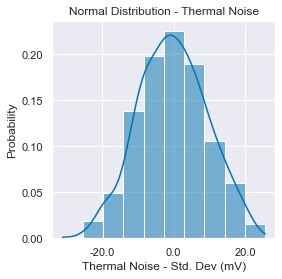

In [30]:
# observe the thermal noise probability density function
fig, ax = plt.subplots(1,1, figsize=(4,4))
freq = int(1)
v_scale = mV
sns.histplot(thermal_noise, ax=ax, stat="probability", bins=10, kde=True)
x_ticks = ax.get_xticks()
ax.set_xticklabels([f"{val/v_scale:.1f}" for val in x_ticks[::freq]])
ax.set_ylabel("Probability")
ax.set_title("Normal Distribution - Thermal Noise")
ax.set_xlabel("Thermal Noise - Std. Dev (mV)")

Text(0.5, 1.0, 'Input signal and output code')

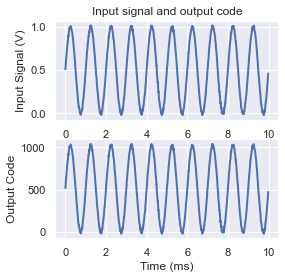

In [31]:
t_scale = 1e-3 # ms
# observe dout and s3
fig, ax = plt.subplots(2, 1, figsize=(4, 4))
ax[0].plot(tD/t_scale, si, color="b", linewidth=2)
ax[0].set_ylabel("Input Signal (V)")    
ax[1].plot(tD/t_scale, dout, color="b", linewidth=2)
ax[1].set_xlabel("Time (ms)")
ax[1].set_ylabel("Output Code")
ax[0].grid(True)
ax[1].grid(True)
ax[0].set_title("Input signal and output code")

In [32]:
# compute the snr of the adc
f_scale = 1e3
p_scale = 1

virt_zero = 1e-30

fD = np.fft.fftshift(np.fft.fftfreq(Np, dt))
# compute the fft of the dout signal 
dout_f = np.abs(np.fft.fftshift(np.fft.fft(dout) / Np))
dout_p = (dout_f*dout_f)
dout_p[dout_p == 0] = virt_zero
dout_db = 10*np.log10(dout_p)

Text(0.5, 1.0, 'Dout Frequency Spectrum - Thermal Noise Superposition')

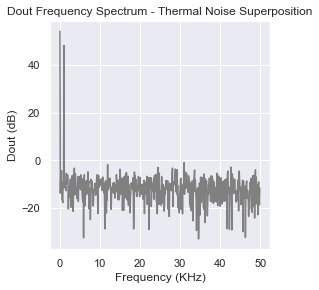

In [33]:
# observe the spectrum
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(
    fD[fD >= 0]/f_scale, dout_db[fD >= 0]/p_scale,
    color="gray",
    marker="None",   
)
ax.grid(True)
ax.set_xlabel("Frequency (KHz)")
ax.set_ylabel("Dout (dB)")
fig.tight_layout()
ax.set_title("Dout Frequency Spectrum - Thermal Noise Superposition")

In [34]:
# compute the snr of the adc
# snr computation 
bins = 1

fDp = fD[fD>=0]
dout_p_fp = dout_p[fD>=0]

fin_bin = fDp[np.argmin(np.abs(f2 - fDp))]
p_in = np.sum(dout_p_fp[fDp == fin_bin][:bins]) # power of the signal

# get an ideal spectrum
ideal_spectrum = np.zeros(len(dout_p_fp))
ideal_spectrum[fDp == fin_bin] = p_in

# compute the noise spectrum, ignoring the dc component
noise_spectrum = dout_p_fp - ideal_spectrum
# compute the noise power of the spectrum
noise = np.mean(noise_spectrum[bins:])
snr = 10*np.log10(p_in/noise)
print(f"Obtained SNR= {snr:.2f} dB")

Obtained SNR= 58.31 dB


<h2 align="left">Quantization Noise Modelling</h2>

<p align="justify">
Each conversion of a signal converter system is prone to <b>quantization error</b>, once the converter parses the signal between the digital and analog domain using a discrete quantization step (Vlsb). As such, each converter signal sample can present an error between [-Vlsb/2 ; Vlsb/2]. Because all systems are subjected to noise, the signal is always superposed by random gaussian noise, and this noise is also converted with the signal in the process of parsing from digital to analog domains. If the superposed noise of the signal doesn't surpass the threshold of |Vlsb/2| level, than the sufficiently random nature of the converted analog signal enables <b>quantization error</b> to be well approximated by white noise - a random noise variable with a uniform distribution of probability - becoming <b>Quantization Noise</b>.
</p>

In [35]:
# define the adc
nbit = 10
vref = 1 
vlsb = vref/(2**nbit)
# define the input signal
A3 = vref/2 # V
f3 = 1e3 # Hz
# setup the input signal frequency to behold 
# coherent sampling
f3 = np.round(f3/Fclk* Np)*Fclk/Np # Hz
ph3 = 0 # rad
mV = 1e-3 # V
dc_level = vref/2
s3 = A3*np.sin(2*np.pi*f3*tD + ph3) + dc_level
# compute the quantization error
p_nq = vlsb**2 / 12 # V**2
vnq = np.sqrt(p_nq) # V
# define the input signal with quantization error
vnq_t = uniform(-vnq, vnq, Np) # V
s3 = s3 + vnq_t
# define the dout 
dout = np.round(s3 / vlsb).astype(int)

/var/folders/vv/xctyh4bd2td6k2w_gvh_t2vr0000gn/T/ipykernel_60821/4039833531.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{val/v_scale:.1f}" for val in x_ticks[::freq]])


Text(0.5, 0, 'Quantization Noise - Std. Dev (mV)')

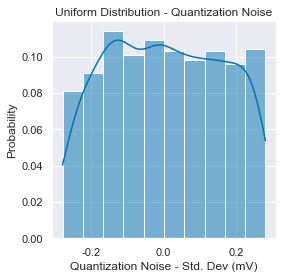

In [36]:
# observe the quantization noise probability density function
fig, ax = plt.subplots(1,1, figsize=(4,4))
freq = int(1)
v_scale = mV
sns.histplot(vnq_t, ax=ax, stat="probability", bins=10, kde=True)
x_ticks = ax.get_xticks()
ax.set_xticklabels([f"{val/v_scale:.1f}" for val in x_ticks[::freq]])
ax.set_ylabel("Probability")
ax.set_title("Uniform Distribution - Quantization Noise")
ax.set_xlabel("Quantization Noise - Std. Dev (mV)")

Text(0.5, 1.0, 'Input signal and output code')

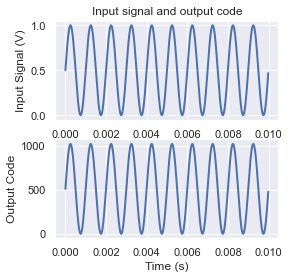

In [37]:

# observe dout and s3
fig, ax = plt.subplots(2, 1, figsize=(4, 4))
ax[0].plot(tD, s3, color="b", linewidth=2)
ax[0].set_ylabel("Input Signal (V)")    
ax[1].plot(tD, dout, color="b", linewidth=2)
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Output Code")
ax[0].grid(True)
ax[1].grid(True)
ax[0].set_title("Input signal and output code")

In [38]:
f_scale = 1e3
p_scale = 1
fD = np.fft.fftshift(np.fft.fftfreq(Np, dt))

new_zero = 1e-30

# compute the fft of the dout signal 
dout_f = np.abs(np.fft.fftshift(np.fft.fft(dout) / Np))
dout_p = (dout_f*dout_f)
dout_p[dout_p == 0] = new_zero # trick to prevent log10 from raising exceptions
dout_db = 10*np.log10(dout_p)


In [39]:
# compute the snr of the adc
# snr computation 
bins = 1

fDp = fD[fD>=0]
dout_p_fp = dout_p[fD>=0]

fin_bin = fDp[np.argmin(np.abs(f3 - fDp))]

p_in = np.sum(dout_p_fp[fDp == fin_bin][:bins]) # power of the signal

# get an ideal spectrum
ideal_spectrum = np.zeros(len(dout_p_fp))
ideal_spectrum[fDp == fin_bin] = p_in

# compute the noise spectrum, ignoring the dc component
noise_spectrum = dout_p_fp - ideal_spectrum
# compute the noise power of the spectrum
noise = np.mean(noise_spectrum[bins:])
snr = 10*np.log10(p_in/noise)
print(f"Obtained SNR= {snr:.2f} dB")

Obtained SNR= 88.86 dB


IMPORTANT NOTE: The obtained SNR considering quantization noise sets the theoretical maximum of the signal-to-noise ratio of the converter.

Text(0.5, 1.0, 'Dout Frequency Spectrum - Quantization Noise Superposition')

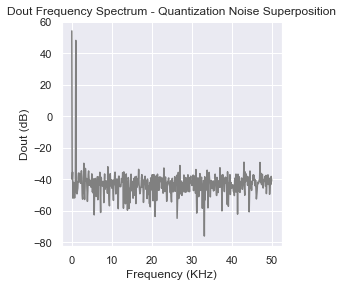

In [40]:
# observe the spectrum
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(
    fD[fD >= 0]/f_scale, dout_db[fD >= 0]/p_scale,
    color="gray",
    marker="None",   
)
ax.grid(True)
ax.set_xlabel("Frequency (KHz)")
ax.set_ylabel("Dout (dB)")
fig.tight_layout()
ax.set_title("Dout Frequency Spectrum - Quantization Noise Superposition")

<h2 align="left"> Total Output Noise </h2>


<p align="justify">
When modelling a converter, the identified "independant" noise soruces must be superposed to the converter's output signal, in order to obtain an accurate measurement of its SNR and linearity, as exemplified in the image below regarding the high-level model of an ideal ADC with superposed noise sources to develop a non-ideal model.
</p>

<p align="center">
<img src="../docs/imgs/total_output_noise.png" width=400>
</p>